In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
from numpy.random import seed
seed(1914)
import tensorflow
tensorflow.random.set_seed(1918)

import numpy as np # linear algebra
import pandas as pd # data processing

import string
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

import os
from sklearn.utils import compute_class_weight
import nltk
import re
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import  utils
from nltk.tokenize import word_tokenize  
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.tokenize import RegexpTokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import  utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPool1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU, Bidirectional, Dropout, MaxPooling1D, Input, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers

stemmer = PorterStemmer()

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to C:\Users\ilkhom-
[nltk_data]     pc\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to C:\Users\ilkhom-
[nltk_data]     pc\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to C:\Users\ilkhom-
[nltk_data]     pc\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to C:\Users\ilkhom-
[nltk_data]     pc\AppData\Roaming\nltk_data...


True

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')
print('Shape train: {}'.format(df_train.shape))
print('Shape test: {}'.format(df_test.shape))
print('Shape sample_submission: {}'.format(sample_submission.shape))

Shape train: (41159, 3)
Shape test: (3798, 2)
Shape sample_submission: (3798, 2)


In [4]:
print('Gaps train: {}'.format(df_train.isnull().sum().sum()))
print('Gaps test: {}'.format(df_test.isnull().sum().sum()))
print('Gaps sample_submission: {}'.format(sample_submission.isnull().sum().sum()))

Gaps train: 6
Gaps test: 0
Gaps sample_submission: 0


In [5]:
df_train = df_train.dropna()
print('Gaps train: {}'.format(df_train.isnull().sum().sum()))
print('Shape train: {}'.format(df_train.shape))

Gaps train: 0
Shape train: (41155, 3)


In [6]:
df_train.sample(9)

,Unnamed: 0,Text,Sentiment
22402,22402,Ok.. this big Bazaar thing is a relief for the...,Negative
17703,17703,Recurring dream...\r\r\n\r\r\nAs I walk in the...,Extremely Positive
7399,7399,Due to the outbreak of COVID-19 Washington sta...,Extremely Positive
20783,20783,While adjusting to the evolving situation of C...,Positive
2865,2865,Indiana Attorney General Curtis Hill is asking...,Negative
35998,35997,I have been doing lots of online shopping this...,Neutral
6183,6183,"Country star Brad Paisley and his wife, Kimber...",Positive
3930,3930,"Due to the #Coronavirus outbreak, we recommend...",Negative
4167,4167,"Live updates: Dow and oil prices plunge, tradi...",Negative


# EDA

In [7]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

def preprocess_text(text, url=False, lower=True, punct=True, stop=True, stem=False, lem=True):

    # Очистка текста от URL-адресов
    if url:
        text = re.sub(r'http\S+', '', text)
    
    # Приведение символов к нижнему регистру
    if lower:
        text = text.lower()

    # Удаление пунктуации
    if punct:
        text = text.translate(str.maketrans("", "", string.punctuation))

    # Удаление стоп-слов
    if stop:
        stop_words = set(stopwords.words('english'))
        words = nltk.word_tokenize(text)
        filtered_words = [word for word in words if word not in stop_words]
        text = " ".join(filtered_words)

    # Стемминг
    if stem:
        porter_stemmer = PorterStemmer()
        words = nltk.word_tokenize(text)
        stemmed_words = [porter_stemmer.stem(word) for word in words]
        text = " ".join(stemmed_words)

    # Лемматизация
    if lem:
        wordnet_lemmatizer = WordNetLemmatizer()
        words = nltk.word_tokenize(text)
        lemmatized_words = [wordnet_lemmatizer.lemmatize(word) for word in words]
        text = " ".join(lemmatized_words)

    return text

In [ ]:
# !unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

In [8]:
text = "Sample text with a lot of punctuation, stop words and urls: https://example.com, http://example.org. Let's stem and lemmatize it!"
processed_text = preprocess_text(text, url=True, punct=True, stop=True, stem=True, lem=False)
print(processed_text)

sampl text lot punctuat stop word url let stem lemmat


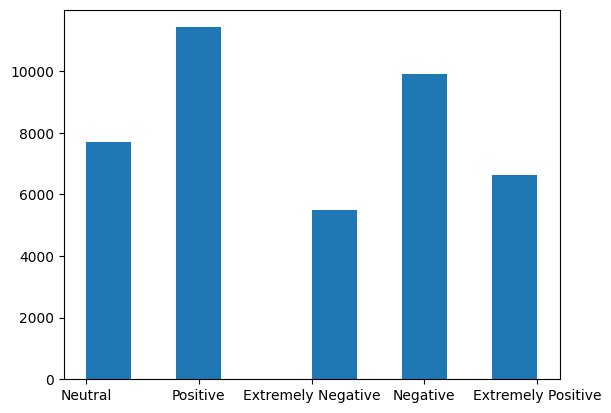

In [9]:
plt.hist(df_train['Sentiment'])
plt.show()

In [10]:
# tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['Text'].values)

# convert texts to numeric with one lenght
train_tokens = tokenizer.texts_to_sequences(df_train['Text'].values)
text_len=[]
for i in range(len(train_tokens)):
  text_len.append(len(train_tokens[i]))
max_text_len = max(text_len)
x_train = pad_sequences(train_tokens, maxlen= max_text_len)

test_tokens = tokenizer.texts_to_sequences(df_test['Text'].values)
x_test = pad_sequences(test_tokens, maxlen= max_text_len)

# encode sentiments
ohe = OneHotEncoder()
y_train = ohe.fit_transform(df_train[['Sentiment']].values)
y_train = y_train.toarray()

In [11]:
# max words count
num_words= 100000
# Sentient count
sentiment_count = 5 
# text lenght
text_len = len(x_train[0])
# compute classes weights
y_train_labels = df_train['Sentiment'].values
class_weights= compute_class_weight(
                                   class_weight = 'balanced',
                                   classes = np.unique(y_train_labels),
                                   y = y_train_labels)
classes = dict(zip(np.unique(y_train_labels), class_weights))
class_weights= {i : class_weights[i] for i in range(5)}
classes

{'Extremely Negative': 1.50173326035395,
 'Extremely Positive': 1.242602657004831,
 'Negative': 0.8299889079358677,
 'Neutral': 1.0674361302036053,
 'Positive': 0.7206268604447558}

In [12]:
# CNN
model_cnn = Sequential()
model_cnn.add(Embedding(num_words, 46, input_length=text_len))
model_cnn.add(Conv1D(128, 5, padding='valid', activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(10, activation='relu'))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(5, activation='softmax'))

In [13]:
model_cnn_save_path = 'best_model_cnn.h5'
checkpoint_callback_cnn = ModelCheckpoint(model_cnn_save_path,
                                          monitor='val_accuracy',
                                          save_best_only=True,
                                          verbose=1)

In [14]:
from tensorflow.keras import models, layers, optimizers

model_cnn.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
history_cnn = model_cnn.fit(x_train,
                            y_train,
                            epochs=5,
                            batch_size=256,
                            class_weight=class_weights,
                            validation_split=0.2)

Epoch 1/5
129/129 [==============================] - 9s 62ms/step - loss: 1.5010 - accuracy: 0.2907 - val_loss: 1.2636 - val_accuracy: 0.4601
Epoch 2/5
129/129 [==============================] - 7s 55ms/step - loss: 1.0120 - accuracy: 0.5370 - val_loss: 0.8759 - val_accuracy: 0.6562
Epoch 3/5
129/129 [==============================] - 7s 54ms/step - loss: 0.7425 - accuracy: 0.6742 - val_loss: 0.8085 - val_accuracy: 0.6790
Epoch 4/5
129/129 [==============================] - 7s 55ms/step - loss: 0.5735 - accuracy: 0.7558 - val_loss: 0.7975 - val_accuracy: 0.6932
Epoch 5/5
129/129 [==============================] - 7s 55ms/step - loss: 0.4390 - accuracy: 0.8159 - val_loss: 0.8305 - val_accuracy: 0.6969


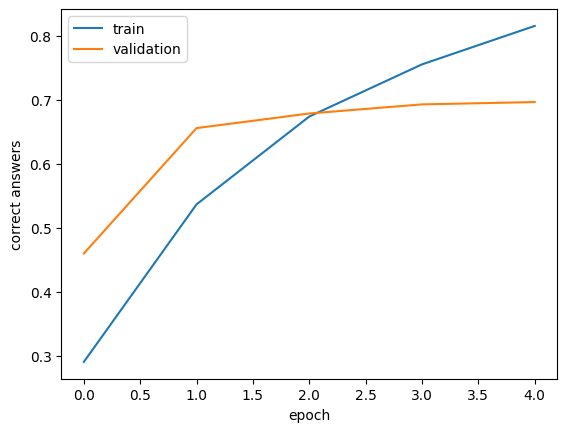

In [16]:
# plot CNN
plt.plot(history_cnn.history['accuracy'],
         label='train')
plt.plot(history_cnn.history['val_accuracy'],
         label='validation')
plt.xlabel('epoch')
plt.ylabel('correct answers')
plt.legend()
plt.show()

In [17]:
pred_test = model_cnn.predict(x_test)
index = np.argmax(pred_test, axis=1) # get index
pred_matrix = np.zeros_like(pred_test) # 0 matrix

pred_matrix[np.arange(len(index)), index.T] = 1 # fill 1 by index

119/119 [==============================] - 0s 2ms/step


In [18]:
ohe.inverse_transform(pred_matrix)

array([['Negative'],
       ['Extremely Positive'],
       ['Extremely Positive'],
       ...,
       ['Neutral'],
       ['Extremely Negative'],
       ['Extremely Positive']], dtype=object)

In [44]:
sample_submission['Sentiment'] = [x[0] for x in ohe.inverse_transform(pred_matrix)]

In [45]:
sample_submission.head()

,id,Sentiment
0,787bc85b-20d4-46d8-84a0-562a2527f684,Negative
1,17e934cd-ba94-4d4f-9ac0-ead202abe241,Extremely Positive
2,5914534b-2b0f-4de8-bb8a-e25587697e0d,Extremely Positive
3,cdf06cfe-29ae-48ee-ac6d-be448103ba45,Negative
4,aff63979-0256-4fb9-a2d9-86a3d3ca5470,Negative


In [47]:
sample_submission.to_csv('submission.csv', index=False)